# theano2-JEC

## Red Neuronal de 1 capa hidden con Theano

In [1]:
# importamos las librerias necesarias
import os
import numpy as np
import pandas as pd
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

theano.__version__

'0.9.0'

In [2]:
# Funcion para cargar los datos de MNIST 

# los lee con Pandas, los convierte a matriz, los randomiza, los normaliza y le agrega targets

def get_normalized_data():
    print("Leyendo y transformando los datos...")

    # originalmente el path era ../large_files/train.csv (pero lo movi para no cargar Dropbox)
    if not os.path.exists('/home/jorge/data/MNIST/train.csv'):
        print('Parece que no existe train.csv')
        print('Bajarlo de https://www.kaggle.com/c/digit-recognizer')
        exit()

    df = pd.read_csv('/home/jorge/data/MNIST/train.csv')
    
    print "Leyendo..."
    data = df.as_matrix().astype(np.float32)
    
    print "Randomizando..."
    np.random.shuffle(data)
    X = data[:, 1:]
    
    print "Normalizando..."    
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std == 0, 1)
    X = (X - mu) / std 
    
    print "Cargando los targets..."
    Y = data[:, 0]
    
    print "Completado"    
    return X, Y

In [3]:
# One-hot encoding
def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [4]:
# Funcion que calcula el error
def error_rate(p, t):
    return np.mean(p != t)


In [5]:
# Versiones anteriores de Theano no tenian la RELU, asi que la definimos por si acaso
def relu(a):
    return a * (a > 0)

### Paso 1: Obtenemos los  datos, definimos las variables de trabajo y asignamos pesos aleatorios

In [6]:
X, Y = get_normalized_data()

max_iter = 20
print_period = 10

lr = 0.00004
reg = 0.01

Xtrain = X[:-2000,]
Ytrain = Y[:-2000]
Xtest  = X[-2000:,]
Ytest  = Y[-2000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

print Xtrain.shape

N, D = Xtrain.shape
batch_sz = 500
n_batches = N / batch_sz

M = 300
K = 10
W1_init = np.random.randn(D, M) / 28
b1_init = np.zeros(M)
W2_init = np.random.randn(M, K) / np.sqrt(M)
b2_init = np.zeros(K)

Leyendo y transformando los datos...
Leyendo...
Randomizando...
Normalizando...
Cargando los targets...
Completado
(40000, 784)


### Paso 2: definimos las matrices que serán INPUT y las variables shared que se actualizan 

In [8]:
# inputs
thX = T.matrix('X')
thT = T.matrix('T')

# shared
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')

### Aqui definimos las operaciones de la capa hidden y de la salida
usamos directamente las funciones incluidas en Theano de la clase del tensor T

In [10]:
thZ = T.nnet.relu(thX.dot(W1) + b1 ) # relu esta incluido en la version 0.7.1... pero por si acaso se incluye
thY = T.nnet.softmax( thZ.dot(W2) + b2 )

### Definimos también la funcion de coste y la funcion que calcula la prediccion

In [11]:
cost = -(thT * T.log(thY)).sum() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())
prediction = T.argmax(thY, axis=1)

### Paso 3: Entrenamos (basicamente es hacer el update de los pesos)

In [12]:
# Incluimos regularizacion como parte del coste porque también es derivado automaticamente!
# update_W1 = W1 - lr*T.grad(cost, W1)
# update_b1 = b1 - lr*T.grad(cost, b1)
# update_W2 = W2 - lr*T.grad(cost, W2)
# update_b2 = b2 - lr*T.grad(cost, b2)

update_W1 = W1 - lr*(T.grad(cost, W1) + reg*W1)
update_b1 = b1 - lr*(T.grad(cost, b1) + reg*b1)
update_W2 = W2 - lr*(T.grad(cost, W2) + reg*W2)
update_b2 = b2 - lr*(T.grad(cost, b2) + reg*b2)


In [13]:
# Para entrenar, debemos indicar los INPUTS y las variables shared que se modifican y como (los UPDATES)
train = theano.function(inputs=[thX, thT],
                        updates=[(W1, update_W1),
                                 (b1, update_b1), 
                                 (W2, update_W2), 
                                 (b2, update_b2)
                                ],
                       )

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl


In [14]:
# creamos otra función para esto porque queremos que pueda atacar todo el dataset
get_prediction = theano.function(inputs=[thX, thT],
                                 outputs=[cost, prediction],
                                )

In [15]:
# Ahora lanzamos la accion

#usamos 2 listas para plotear como evoluciona la funcion de coste y el error
costs = []
error = []

for i in xrange(max_iter):
    for j in xrange(n_batches):      # en Xbatch, Ybatch cargamos los datos de cada batch
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)        # ejecutamos la funcion train que habiamos definido con sus INPUTS
                                     # para actualizar los pesos    
        if j % print_period == 0:
            # para cada iteracion calculamos el coste, la prediccion y el error
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            
            print "Coste y error en la iteracion i=%d, j=%d: %.3f / %.3f" % (i, j, cost_val, err)
            costs.append(cost_val)
            error.append(err)

Coste y error en la iteracion i=0, j=0: 4975.132 / 0.909
Coste y error en la iteracion i=0, j=10: 3770.513 / 0.551
Coste y error en la iteracion i=0, j=20: 2982.957 / 0.342
Coste y error en la iteracion i=0, j=30: 2467.666 / 0.271
Coste y error en la iteracion i=0, j=40: 2117.387 / 0.220
Coste y error en la iteracion i=0, j=50: 1864.236 / 0.208
Coste y error en la iteracion i=0, j=60: 1673.495 / 0.188
Coste y error en la iteracion i=0, j=70: 1528.148 / 0.171
Coste y error en la iteracion i=1, j=0: 1411.589 / 0.160
Coste y error en la iteracion i=1, j=10: 1319.070 / 0.153
Coste y error en la iteracion i=1, j=20: 1242.615 / 0.147
Coste y error en la iteracion i=1, j=30: 1177.311 / 0.140
Coste y error en la iteracion i=1, j=40: 1123.124 / 0.136
Coste y error en la iteracion i=1, j=50: 1076.121 / 0.133
Coste y error en la iteracion i=1, j=60: 1034.385 / 0.130
Coste y error en la iteracion i=1, j=70: 998.377 / 0.126
Coste y error en la iteracion i=2, j=0: 965.312 / 0.122
Coste y error en la

Coste y error en la iteracion i=17, j=70: 442.908 / 0.062
Coste y error en la iteracion i=18, j=0: 442.485 / 0.059
Coste y error en la iteracion i=18, j=10: 442.061 / 0.061
Coste y error en la iteracion i=18, j=20: 441.541 / 0.062
Coste y error en la iteracion i=18, j=30: 440.556 / 0.062
Coste y error en la iteracion i=18, j=40: 439.194 / 0.061
Coste y error en la iteracion i=18, j=50: 438.015 / 0.062
Coste y error en la iteracion i=18, j=60: 436.591 / 0.061
Coste y error en la iteracion i=18, j=70: 435.858 / 0.059
Coste y error en la iteracion i=19, j=0: 435.486 / 0.059
Coste y error en la iteracion i=19, j=10: 435.106 / 0.059
Coste y error en la iteracion i=19, j=20: 434.634 / 0.060
Coste y error en la iteracion i=19, j=30: 433.738 / 0.060
Coste y error en la iteracion i=19, j=40: 432.437 / 0.059
Coste y error en la iteracion i=19, j=50: 431.297 / 0.061
Coste y error en la iteracion i=19, j=60: 429.917 / 0.060
Coste y error en la iteracion i=19, j=70: 429.223 / 0.059


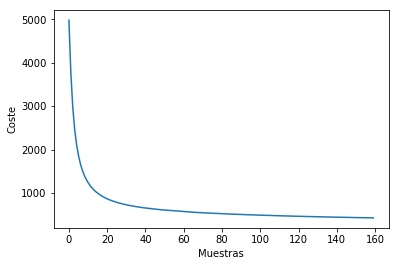

In [16]:
plt.xlabel("Muestras")
plt.ylabel("Coste")
plt.plot(costs)
plt.show()

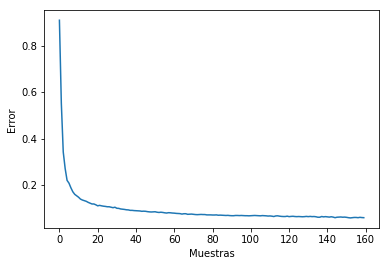

In [17]:
plt.xlabel("Muestras")
plt.ylabel("Error")
plt.plot(error)
plt.show()